# Code for Identifying Breakpoints

This notebook contains the analysis which corresponds to the figures in the chapter related to breakpoint analysis.

In [1]:
from transformers import T5ForConditionalGeneration, AutoTokenizer
from alphaarc.task import Task
import torch
import matplotlib.pyplot as plt
import numpy as np 
import json
import torch, tqdm, pickle
from pathlib import Path
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from transformers import T5ForConditionalGeneration, AutoTokenizer
from alphaarc.task import Task
import torch
import matplotlib.pyplot as plt
import numpy as np 
import json
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
with open('../data/split_keys.json') as fp:
    json_object = json.load(fp)

validation_tasks = json_object['val']

validation_tasks

['6150a2bd',
 'c8f0f002',
 '68b16354',
 'c9e6f938',
 '6fa7a44f',
 'ac0a08a4',
 '4258a5f9',
 '9ecd008a',
 '25ff71a9',
 '3af2c5a8',
 '67e8384a',
 '56ff96f3',
 'dc1df850',
 'ae4f1146',
 'aabf363d',
 'aedd82e4',
 '445eab21',
 '41e4d17e',
 'f5b8619d',
 '00d62c1b',
 '3906de3d',
 '8d5021e8',
 '0ca9ddb6',
 'd0f5fe59',
 'ba97ae07',
 'd9fac9be',
 'ded97339',
 'f8ff0b80',
 'dbc1a6ce',
 '496994bd',
 'fcb5c309',
 'ff805c23',
 '5c0a986e',
 '7f4411dc',
 '6d75e8bb',
 'e76a88a6',
 '8f2ea7aa',
 '137eaa0f',
 '6e82a1ae',
 'a5f85a15',
 '4be741c5',
 '681b3aeb',
 '3ac3eb23',
 '253bf280',
 '3428a4f5',
 'a9f96cdd',
 '1caeab9d',
 '3de23699',
 'bdad9b1f',
 '88a62173',
 'f8b3ba0a',
 '88a10436',
 '7e0986d6',
 'd4a91cb9',
 '913fb3ed',
 '3631a71a',
 '95990924',
 '93b581b8',
 '9edfc990',
 'a65b410d',
 'ef135b50',
 '6e19193c',
 'cbded52d',
 'ae3edfdc',
 '4612dd53',
 'e48d4e1a',
 '846bdb03',
 '2204b7a8',
 'e5062a87',
 '539a4f51',
 '91413438',
 'e8dc4411',
 'e40b9e2f',
 'd6ad076f',
 'b190f7f5',
 '6cdd2623',
 'f9012d9b',

## Code for Generating Sequence Level Probabilities

['6150a2bd', 'c8f0f002', '68b16354', 'c9e6f938', '6fa7a44f', 'ac0a08a4', '4258a5f9', '9ecd008a', '25ff71a9', '3af2c5a8', '67e8384a', '56ff96f3', 'dc1df850', 'ae4f1146', 'aabf363d', 'aedd82e4', '445eab21', '41e4d17e', 'f5b8619d', '00d62c1b', '3906de3d', '8d5021e8', '0ca9ddb6', 'd0f5fe59', 'ba97ae07', 'd9fac9be', 'ded97339', 'f8ff0b80', 'dbc1a6ce', '496994bd', 'fcb5c309', 'ff805c23', '5c0a986e', '7f4411dc', '6d75e8bb', 'e76a88a6', '8f2ea7aa', '137eaa0f', '6e82a1ae', 'a5f85a15', '4be741c5', '681b3aeb', '3ac3eb23', '253bf280', '3428a4f5', 'a9f96cdd', '1caeab9d', '3de23699', 'bdad9b1f', '88a62173', 'f8b3ba0a', '88a10436', '7e0986d6', 'd4a91cb9', '913fb3ed', '3631a71a', '95990924', '93b581b8', '9edfc990', 'a65b410d', 'ef135b50', '6e19193c', 'cbded52d', 'ae3edfdc', '4612dd53', 'e48d4e1a', '846bdb03', '2204b7a8', 'e5062a87', '539a4f51', '91413438', 'e8dc4411', 'e40b9e2f', 'd6ad076f', 'b190f7f5', '6cdd2623', 'f9012d9b', 'e21d9049', 'eb5a1d5d', '0a938d79', '82819916', 'a78176bb', '952a094c', '98

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


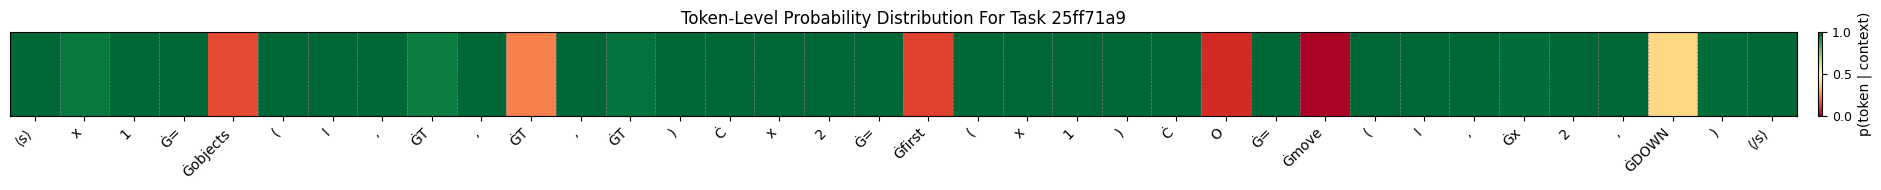

In [5]:
from alphaarc.policy.tokenize import tokenize_task

def encode_task(task, tokenizer, model, input_state_max=256, n_examples=10, max_length=256): 
    tokenized_task = np.array(tokenize_task(task, tokenizer, n_examples, input_state_max, max_length)['input_ids'])
    return tokenized_task


def output_program_lines(task):
    print(f"=== Task {task.task_key} Program ===")

    print(task.program_lines)


def compute_logits(task, model, ): 
    tok      = AutoTokenizer.from_pretrained('Salesforce/codet5p-220m')
    target_text = task.program_lines
    model.eval()

    # teacher-forcing forward pass
    input_   = torch.tensor(encode_task(task, tok, model)).unsqueeze(0)

    ids      = tok(target_text, return_tensors="pt").input_ids

    with torch.no_grad():
        logits = model(input_, labels =ids).logits        # [1, seq_len, vocab]
    
    log_p     = torch.log_softmax(logits, -1)

    token_logp = log_p.gather(2, ids.unsqueeze(-1)).squeeze(-1)  
    p_token    = token_logp.exp().squeeze().tolist()            
    tokens     = tok.convert_ids_to_tokens(ids[0])

    return tokens, p_token


 
def output_correct_token_probs(task_id, tokens, p_token): 
    fig, ax = plt.subplots(figsize=(len(tokens) * 0.6, 2))
    im = ax.imshow(np.array([p_token]), aspect="auto", cmap="RdYlGn", vmin=0, vmax=1)

    display_tokens = [t.replace("<s>", "⟨s⟩").replace("</s>", "⟨/s⟩") for t in tokens]

    ax.set_yticks([])
    ax.set_xticks(range(len(tokens)))
    ax.set_xticklabels(display_tokens, rotation=45, ha="right", fontsize=10)
    
    ax.set_xticks(np.arange(-.5, len(tokens), 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='x', which='minor', bottom=False)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax, pad=0.01)
    cbar.set_label("p(token | context)", fontsize=10)
    cbar.ax.tick_params(labelsize=9)

    plt.title(f"Token-Level Probability Distribution For Task {task_id}")
    plt.tight_layout()
    plt.savefig('../figures/sequence-level-probs.png')
    plt.show()

def generate_task_level_analysis(task_id, model_path='../finetune/2025-05-27_17-42-37/checkpoint-1100'): 
    task = Task.from_json(f'../data/training/{task_id}.json')
    model = T5ForConditionalGeneration.from_pretrained(model_path)
    output_program_lines(task)
    tokens, p_token = compute_logits(task, model)
    output_correct_token_probs(task.task_key, tokens, p_token)


print(validation_tasks)
# change here the task and model you wish to use.
task = validation_tasks[8]
generate_task_level_analysis(task, model_path='../finetune/2025-06-16_01-31-36/checkpoint-80')

## Code for Generating Correct Token Probability Across Dataset

In [4]:
from collections import Counter

def token_stats(logits, ids):
    log_p = torch.log_softmax(logits, -1)           # [1, L, V]
    probs = log_p.exp()

    entropy = -(probs * log_p).sum(-1).squeeze(0)   # [L]  (nats)

    # top-1 correctness
    top1_ids = logits.argmax(-1)                    # [1, L]
    is_correct = (top1_ids == ids).float().squeeze(0)

    p_true = probs.gather(2, ids.unsqueeze(-1)).squeeze(0).squeeze(-1)

    return entropy.cpu(), is_correct.cpu(), p_true.cpu()


def compute_logits(task, model, tokenizer):
    target_text = task.program_lines
    model.eval()

    input_ids = torch.tensor(
        encode_task(task, tokenizer, model)
    ).unsqueeze(0).to(model.device)

    ids = tokenizer(target_text, return_tensors="pt").input_ids.to(model.device)

    with torch.no_grad():
        logits = model(input_ids, labels=ids).logits

    entropy, is_correct, p_true = token_stats(logits, ids)

    
    log_p       = torch.log_softmax(logits, -1)
    token_logp  = log_p.gather(2, ids.unsqueeze(-1)).squeeze(-1)
    p_token     = token_logp.exp().squeeze().tolist()
    tokens      = tokenizer.convert_ids_to_tokens(ids[0])
    return tokens, p_token, entropy



def compute_correct_token_probs(tasks, model_path, tokenizer_path='Salesforce/codet5p-220m'): 
    model = T5ForConditionalGeneration.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    
    token_probs = []
    all_tokens = []

    for task_id in tasks:
        task = Task.from_json(f'../data/training/{task_id}.json')
        tokens, p_token, _ = compute_logits(task, model, tokenizer)

        token_probs.extend(p_token)
        all_tokens.extend(tokens)
    
    return token_probs, all_tokens


def plot_correct_token_probs(result, filename):
    from collections import Counter

    correct_token_probs, tokens = result
    
    # Count how frequently each token appears
    token_freq = Counter(tokens)
    weights = [1 / token_freq[token] for token in tokens]

    # Plot with weights
    plt.figure(figsize=(8, 5))
    plt.hist(correct_token_probs, bins=20, range=(0, 1), weights=weights, edgecolor='black', alpha=0.7)
    plt.title('Length-Normalized Histogram of Probabilities Assigned to Correct Tokens')
    plt.xlabel('Probability Assigned to Correct Token')
    plt.ylabel('Normalized Token Contribution')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(filename)

    plt.show()




### For Final Model

Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors


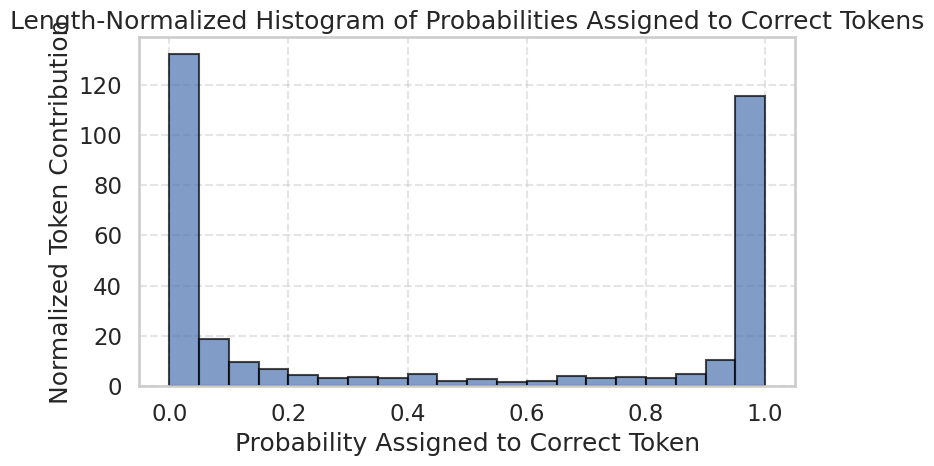

In [70]:


result = compute_correct_token_probs(validation_tasks,
                                                  '../finetune/2025-06-16_01-31-36/checkpoint-80')
plot_correct_token_probs(result, filename='../figures/main-model-histogram.png')

### For Different Stages of Training

#### Example Plots

Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors


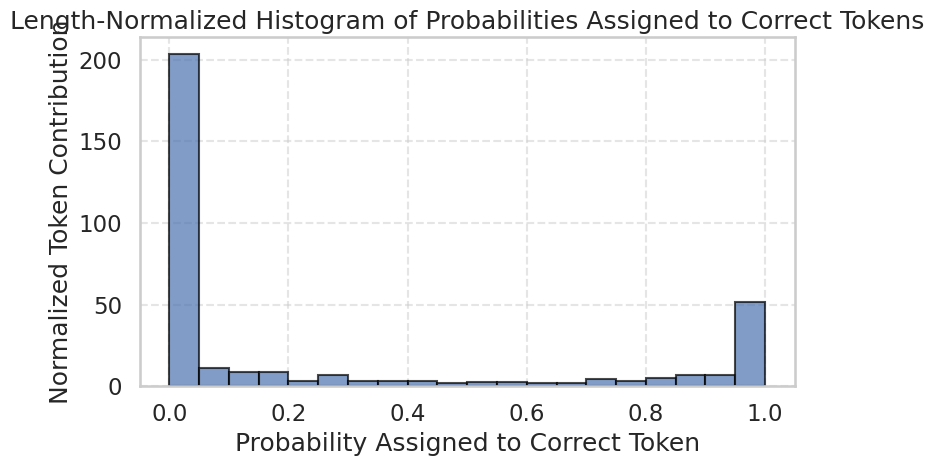

Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors


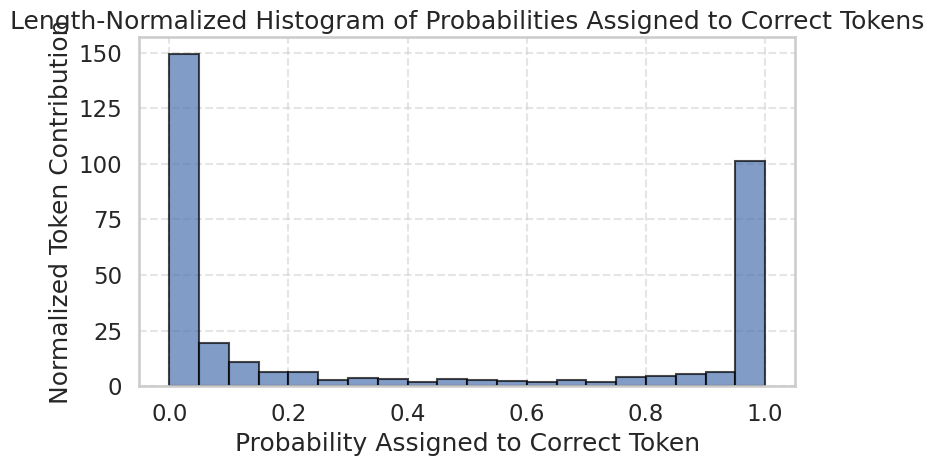

Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors


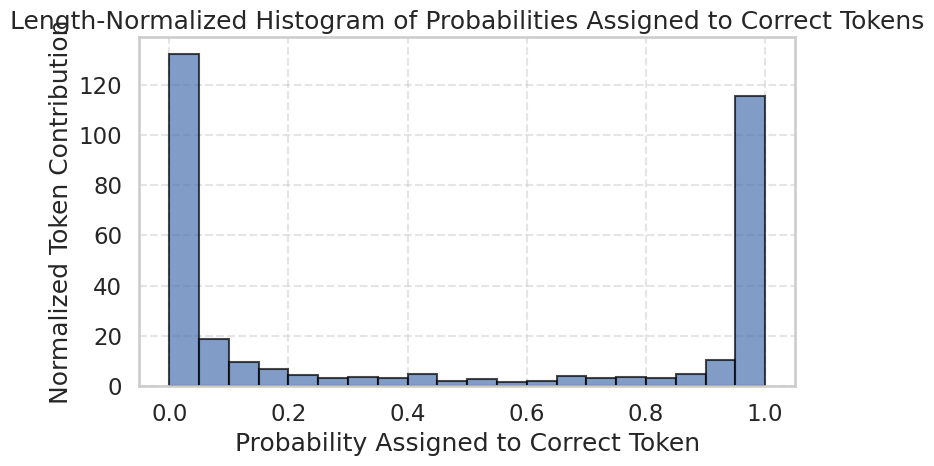

Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors


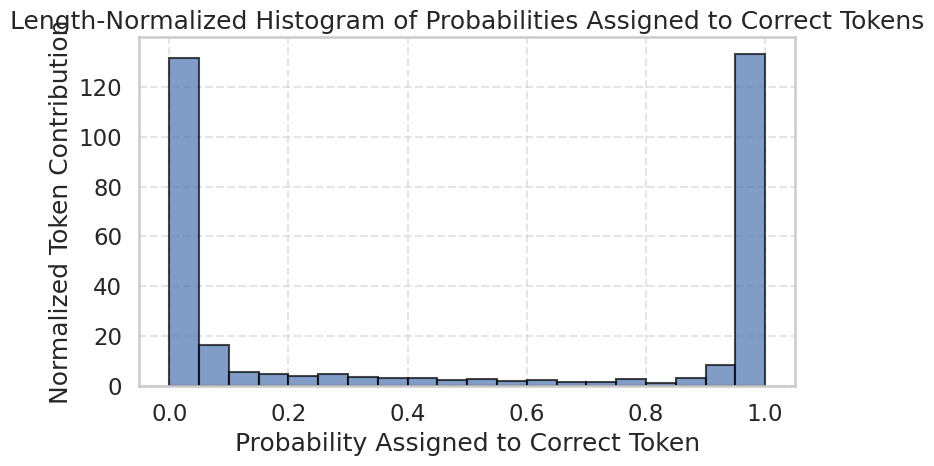

In [71]:
plot_correct_token_probs(compute_correct_token_probs(validation_tasks,
                                                  '../finetune/2025-06-16_01-31-36/checkpoint-10'), '../figures/1-histogram.png')
plot_correct_token_probs(compute_correct_token_probs(validation_tasks,
                                                  '../finetune/2025-06-16_01-31-36/checkpoint-40'), '../figures/2-histogram.png')
plot_correct_token_probs(compute_correct_token_probs(validation_tasks,
                                                  '../finetune/2025-06-16_01-31-36/checkpoint-80'), '../figures/3-histogram.png')

plot_correct_token_probs(compute_correct_token_probs(validation_tasks,
                                                  '../finetune/2025-06-16_01-31-36/checkpoint-200'),'../figures/4-histogram.png')

#### Heatmap

In [110]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import T5ForConditionalGeneration, AutoTokenizer
from collections import Counter

def get_checkpoints(path_prefix):
    return sorted(
        [os.path.join(path_prefix, ckpt) for ckpt in os.listdir(path_prefix) if ckpt.startswith("checkpoint-")],
        key=lambda x: int(x.split("-")[-1])
    )

def compute_histogram(result, num_bins=20):
    correct_token_probs, tokens = result
    token_freq = Counter(tokens)
    weights = np.array([1 / token_freq[token] for token in tokens])

    hist, bin_edges = np.histogram(correct_token_probs, bins=num_bins, range=(0, 1), weights=weights, density=False)
    return hist, bin_edges

def build_heatmap_matrix(checkpoint_paths, tasks, tokenizer_path='Salesforce/codet5p-220m'):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    histograms = []
    steps = []

    for path in checkpoint_paths:
        step = int(path.split("-")[-1])
        model = T5ForConditionalGeneration.from_pretrained(path)
        result = compute_correct_token_probs(tasks, path, tokenizer_path)
        hist, bin_edges = compute_histogram(result)
        histograms.append(hist)
        steps.append(step)

    return np.array(histograms).T, np.array(steps), bin_edges  # Transposed so bins are rows

def plot_flipped_heatmap(hist_matrix, steps, bin_edges, save_path='../figures/training-step-heat-map.png'):
    fig, ax = plt.subplots(figsize=(12, 6))
    im = ax.imshow(hist_matrix, aspect='auto', cmap='viridis', origin='lower',
                   extent=[steps[0], steps[-1], bin_edges[0], bin_edges[-1]])

    ax.set_xticks(steps)
    ax.set_xticklabels([i for i in range(len(steps))])
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Probability Assigned to Correct Token')
    ax.set_title('Probability Heatmap Throughout Training Steps')
    plt.colorbar(im, label='Normalized Token Contribution')
    plt.grid(False)
    plt.tight_layout()
    plt.show()
    plt.savefig(save_path)




In [73]:
checkpoint_dir = '../finetune/2025-06-16_01-31-36'
checkpoints = get_checkpoints(checkpoint_dir)
hist_matrix, steps, bin_edges = build_heatmap_matrix(checkpoints, validation_tasks)

Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

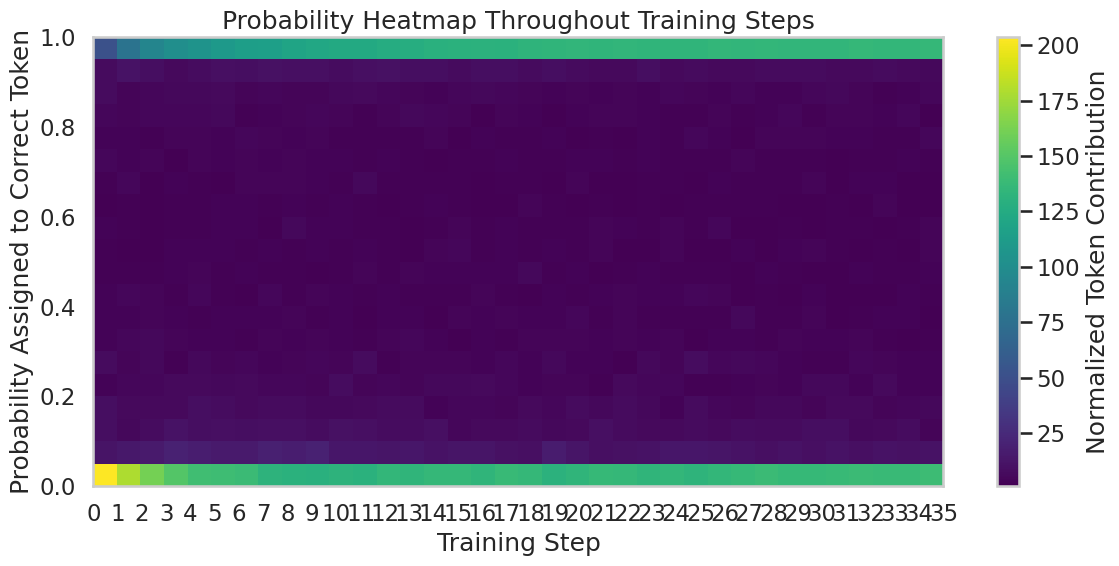

<Figure size 640x480 with 0 Axes>

In [111]:
plot_flipped_heatmap(hist_matrix, steps, bin_edges)

## Code for Displaying Entropy-Relationship

### Code for Representative Breakpoint

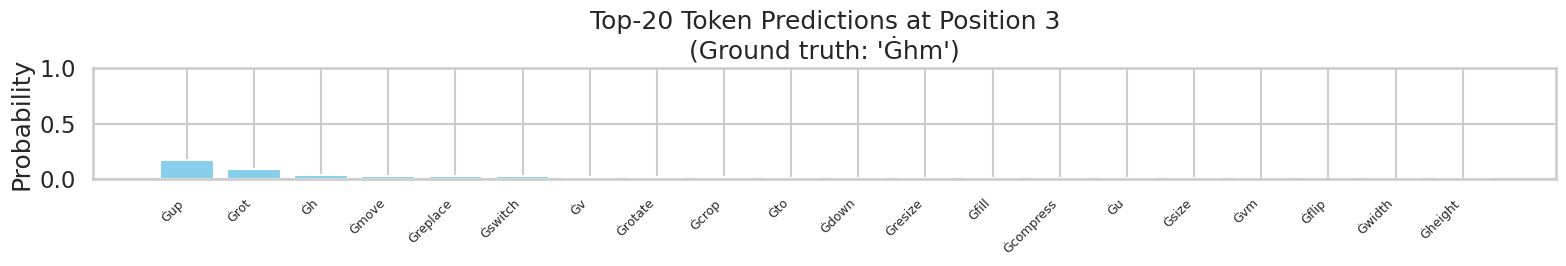

In [105]:
import matplotlib.pyplot as plt
import numpy as np



def compute_logits(task, model, tokenizer):
    target_text = task.program_lines
    model.eval()

    input_ids = torch.tensor(
        encode_task(task, tokenizer, model)
    ).unsqueeze(0).to(model.device)

    ids = tokenizer(target_text, return_tensors="pt").input_ids.to(model.device)

    with torch.no_grad():
        logits = model(input_ids, labels=ids).logits

    entropy, is_correct, p_true = token_stats(logits, ids)

    
    log_p       = torch.log_softmax(logits, -1)
    token_logp  = log_p.gather(2, ids.unsqueeze(-1)).squeeze(-1)
    p_token     = token_logp.exp().squeeze().tolist()
    tokens      = tokenizer.convert_ids_to_tokens(ids[0])

    probs = torch.softmax(logits, dim=-1)[0].cpu().numpy()  # Shape: (T, V)
    return tokens, probs



def compute_probs_for_task(task_id, model_path, tokenizer_path='Salesforce/codet5p-220m'):
    model = T5ForConditionalGeneration.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    

    task = Task.from_json(f'../data/training/{task_id}.json')
    tokens, probs = compute_logits(task, model, tokenizer)


    return tokens, probs

def output_token_distributions_topk(task_id, tokens, p_token, tokenizer, top_k=10):
    """
    tokens: list of ground-truth tokens (len = sequence length)
    p_token: array of shape (sequence length, vocab size)
    tokenizer: a tokenizer object with `convert_ids_to_tokens()` method
    top_k: number of top tokens to show per timestep
    """
    import matplotlib.pyplot as plt
    import numpy as np

    seq_len, vocab_size = p_token.shape
    fig, axs = plt.subplots(1, seq_len, figsize=(seq_len * 1.5, 3), sharey=True)

    if seq_len == 1:
        axs = [axs]

    display_tokens = [t.replace("<s>", "⟨s⟩").replace("</s>", "⟨/s⟩") for t in tokens]

    for i, (ax, dist, label) in enumerate(zip(axs, p_token, display_tokens)):
        topk_idx = np.argsort(dist)[-top_k:][::-1]
        topk_probs = dist[topk_idx]
        topk_labels = tokenizer.convert_ids_to_tokens(topk_idx)

        ax.bar(range(top_k), topk_probs, color='skyblue')
        ax.set_xticks(range(top_k))
        ax.set_xticklabels(topk_labels, rotation=45, ha='right', fontsize=7)
        ax.set_ylim(0, 1)
        ax.set_yticks([0, 0.5, 1])
        ax.set_title(label, fontsize=9)

    fig.suptitle(f"Top-{top_k} Token Distributions for Task {task_id}", fontsize=12)
    plt.tight_layout()
    plt.subplots_adjust(top=0.75)
    plt.savefig('../figures/topk-token-distributions.png')
    plt.show()

import matplotlib.pyplot as plt
import numpy as np

def output_token_distribution_at_position(task_id, tokens, probs, tokenizer, position=0, top_k=10):
    """
    Visualizes top-k token probabilities at a single position in the sequence.

    Parameters:
        task_id: identifier for the task (used in title/saving)
        tokens: list of ground-truth tokens (sequence)
        probs: np.ndarray of shape (seq_len, vocab_size)
        tokenizer: Hugging Face tokenizer (used to decode token ids)
        position: int — index of the token position to visualize
        top_k: int — number of top tokens to show
    """
    if isinstance(probs, list):
        probs = np.array(probs)

    if probs.ndim != 2:
        raise ValueError("Expected `probs` to have shape (sequence_length, vocab_size)")

    if position >= len(tokens):
        raise IndexError(f"Position {position} out of range for sequence of length {len(tokens)}")

    token_probs = probs[position]  # shape: (vocab_size,)
    topk_idx = np.argsort(token_probs)[-top_k:][::-1]
    topk_probs = token_probs[topk_idx]
    topk_tokens = tokenizer.convert_ids_to_tokens(topk_idx)

    plt.figure(figsize=(top_k * 0.8, 3))
    bars = plt.bar(range(top_k), topk_probs, color='skyblue')
    plt.xticks(range(top_k), topk_tokens, rotation=45, ha='right', fontsize=9)
    plt.ylim(0, 1)
    plt.ylabel("Probability")
    plt.title(f"Top-{top_k} Token Predictions at Position {position}\n(Ground truth: '{tokens[position]}')")

    # Optionally highlight the true token in red if it's in top-k
    true_token = tokens[position]
    try:
        true_token_id = tokenizer.convert_tokens_to_ids(true_token)
        if true_token_id in topk_idx:
            idx_in_topk = list(topk_idx).index(true_token_id)
            bars[idx_in_topk].set_color('green')
    except:
        pass  # token not found or unknown token

    plt.tight_layout()
    plt.savefig(f'../figures/topk-token-distribution-pos{position}.png')
    plt.show()


task_id= '68b16354'
tokens, p_token = compute_probs_for_task(task_id,  model_path='../finetune/2025-06-16_01-31-36/checkpoint-80')


output_token_distribution_at_position(task_id, tokens, p_token, AutoTokenizer.from_pretrained('Salesforce/codet5p-220m'), position= 3, top_k=20)

### Code for Heatmap

Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors


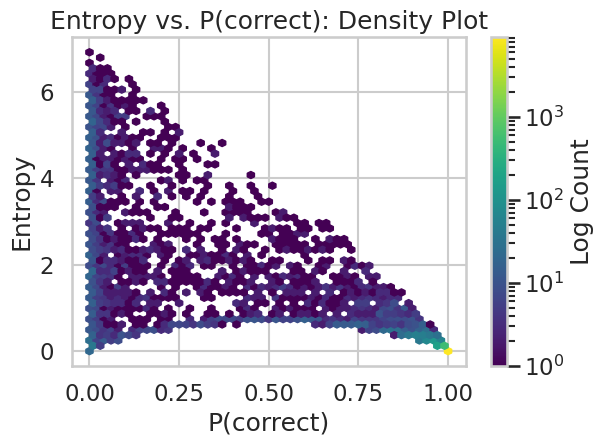

In [77]:
def compute_logits(task, model, tokenizer):
    target_text = task.program_lines
    model.eval()

    input_ids = torch.tensor(
        encode_task(task, tokenizer, model)
    ).unsqueeze(0).to(model.device)

    ids = tokenizer(target_text, return_tensors="pt").input_ids.to(model.device)

    with torch.no_grad():
        logits = model(input_ids, labels=ids).logits

    entropy, is_correct, p_true = token_stats(logits, ids)

    
    log_p       = torch.log_softmax(logits, -1)
    token_logp  = log_p.gather(2, ids.unsqueeze(-1)).squeeze(-1)
    p_token     = token_logp.exp().squeeze().tolist()
    tokens      = tokenizer.convert_ids_to_tokens(ids[0])
    return tokens, p_token, entropy


def compute_probs_and_entropies(tasks, model_path, tokenizer_path='Salesforce/codet5p-220m'): 
    model = T5ForConditionalGeneration.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    
    token_probs = []
    entropies = []
    for task_id in tasks:
        task = Task.from_json(f'../data/training/{task_id}.json')
        _, p_token, entropy = compute_logits(task, model, tokenizer)

        token_probs.extend(p_token)
        entropies.extend(entropy)

    return np.array(token_probs), np.array(entropies)




def display_scatter_plot(correct_probs, entropies): 

    # Create mask for low-confidence predictions (P < 0.1)
    low_conf_mask = correct_probs < 0.1
    
    # Plot
    plt.figure(figsize=(8, 5))
    plt.scatter(correct_probs[low_conf_mask], entropies[low_conf_mask],
                color='red', alpha=0.6, label='P(correct) < 0.1')

    plt.scatter(correct_probs[~low_conf_mask], entropies[~low_conf_mask],
                color='blue', alpha=0.6, label='P(correct) > 0.1')

    plt.title('Entropy vs. Probability Assigned to Correct Token (Low-Confidence)')
    plt.xlabel('Probability Assigned to Correct Token')
    plt.ylabel('Entropy of Token Distribution')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()



def display_hex_bin(correct_probs, entropies):


    plt.hexbin(correct_probs, entropies, gridsize=50, cmap='viridis', bins='log')
    plt.colorbar(label='Log Count')
    plt.xlabel('P(correct)')
    plt.ylabel('Entropy')
    plt.title('Entropy vs. P(correct): Density Plot')
    plt.tight_layout()
    plt.savefig('../figures/entropy-hexbin.png')
    plt.show()


def display_violin_plots(correct_probs, entropies): 
   
    data = pd.DataFrame({
        'P_correct': correct_probs,
        'entropy': entropies
    })

    # Bin the P(correct) values
    data['bucket'] = pd.cut(data['P_correct'], bins=np.linspace(0, 1, 11), include_lowest=True)

    # Plot violin plot of entropy distributions per bucket
    plt.figure(figsize=(10, 5))
    sns.violinplot(x='bucket', y='entropy', data=data, inner='quartile', scale='width')
    plt.title('Distribution of Entropy per P(correct) Bucket')
    plt.xlabel('P(correct) Bucket')
    plt.ylabel('Entropy')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


correct_probs, entropies = compute_probs_and_entropies(validation_tasks,  '../finetune/2025-06-16_01-31-36/checkpoint-80' )
display_hex_bin(correct_probs, entropies)

## Code for Plotting Token Types

Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors


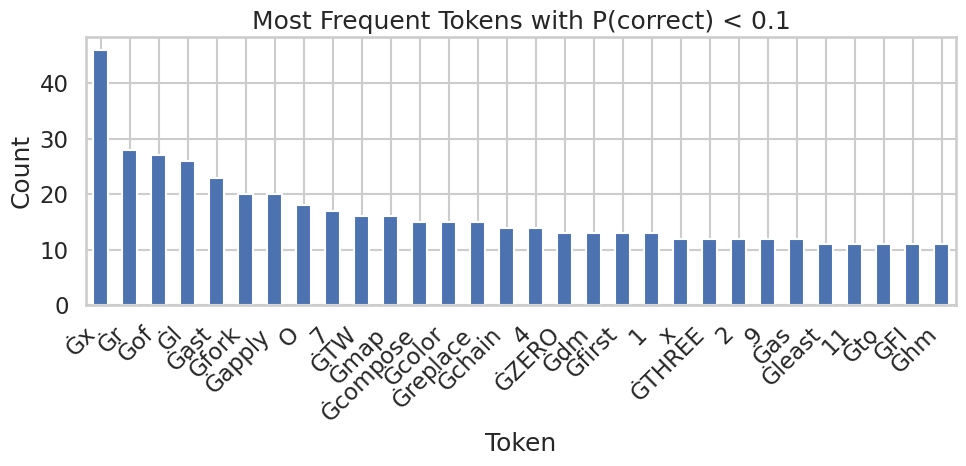

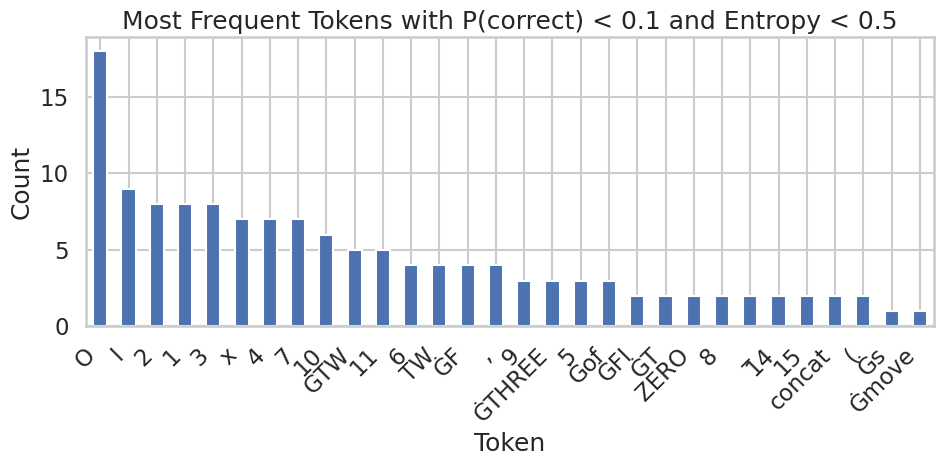

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", context="talk")


def compute_probs_and_token_ids(tasks, model_path, tokenizer_path='Salesforce/codet5p-220m'): 
    model = T5ForConditionalGeneration.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    
    token_probs = []
    tokens = []
    entropies = []
    for task_id in tasks:
        task = Task.from_json(f'../data/training/{task_id}.json')
        t, p_token, ent = compute_logits(task, model, tokenizer)

        tokens.extend(t)
        token_probs.extend(p_token)
        entropies.extend(ent)

    return tokens, token_probs, entropies



def display_token_type_data(dataframe): 
    low_conf_df = df[df['p_correct'] < 0.1]

    token_counts = low_conf_df['token'].value_counts().head(30)

    plt.figure(figsize=(10, 5))
    token_counts.plot(kind='bar')
    plt.title('Most Frequent Tokens with P(correct) < 0.1')
    plt.xlabel('Token')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('../figures/low-prob-correct-tokens.png')
    plt.show()


def display_token_type_and_overconfident_data(dataframe): 
    low_conf_df = df[(df['p_correct'] < 0.1) & (df['entropies'] < 0.5)]
    
    token_counts = low_conf_df['token'].value_counts().head(30)

    plt.figure(figsize=(10, 5))
    token_counts.plot(kind='bar')
    plt.title('Most Frequent Tokens with P(correct) < 0.1 and Entropy < 0.5')
    plt.xlabel('Token')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('../figures/low-prob-correct-tokens-low-entropy.png')
    plt.show()






tokens, token_probs, entropies = compute_probs_and_token_ids(validation_tasks, '../finetune/2025-06-16_01-31-36/checkpoint-80' )

df = pd.DataFrame({
    'token': tokens,
    'p_correct': token_probs, 
    'entropies': entropies
})

display_token_type_data(df )
display_token_type_and_overconfident_data(df)

# Code for DSL Level Analysis

Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors


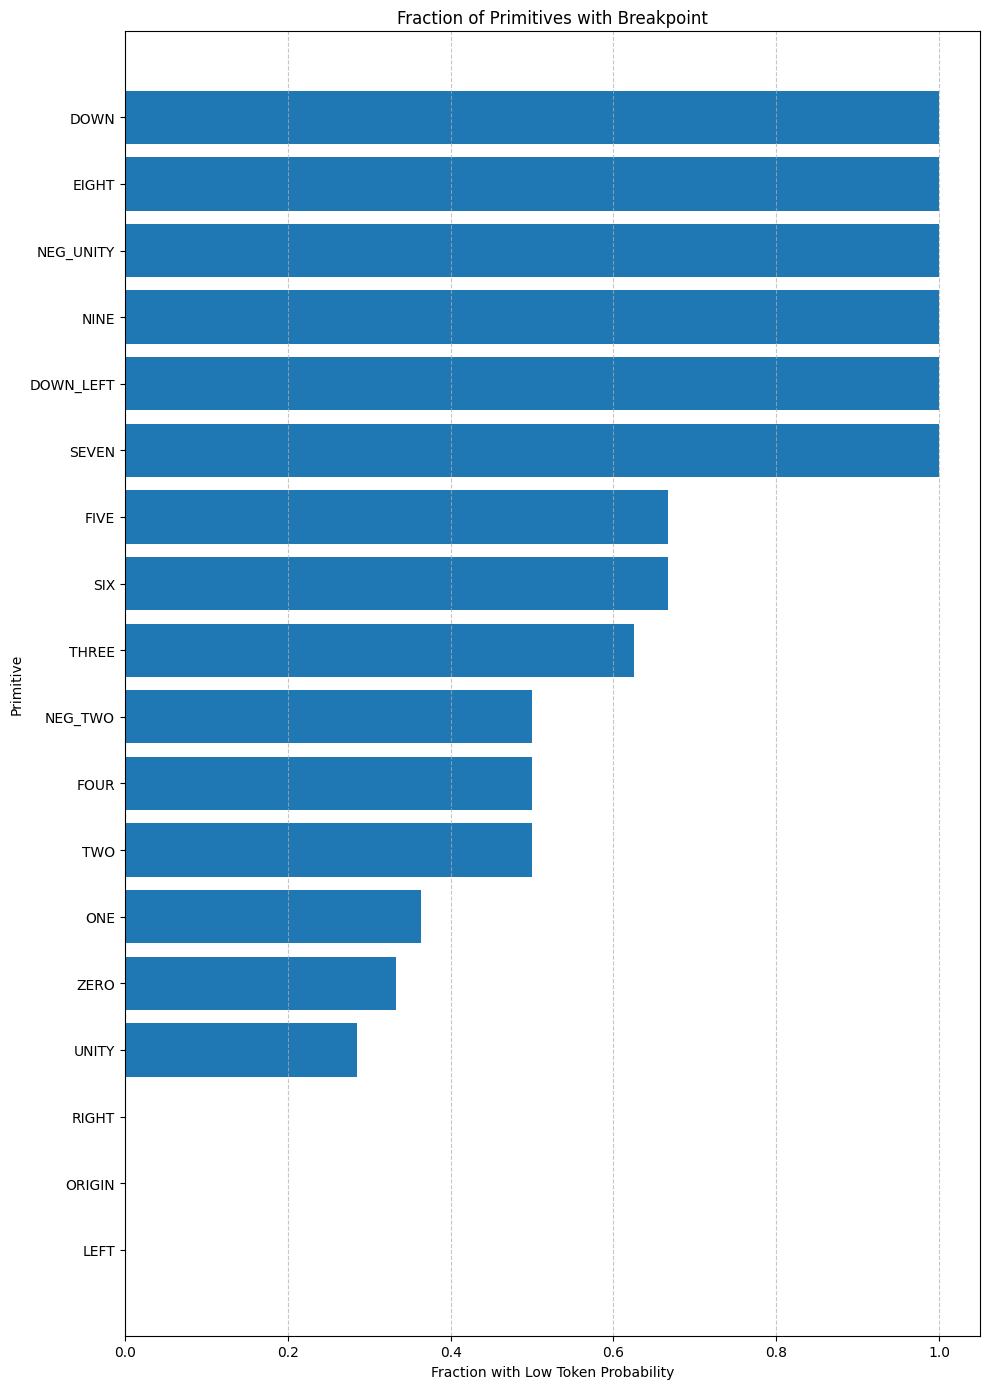

In [13]:

def compute_logits(task, model, tokenizer):
    target_text = task.program_lines
    model.eval()

    input_ids = torch.tensor(
        encode_task(task, tokenizer, model)
    ).unsqueeze(0).to(model.device)

    ids = tokenizer(target_text, return_tensors="pt").input_ids.to(model.device)

    with torch.no_grad():
        logits = model(input_ids, labels=ids).logits

    entropy, is_correct, p_true = token_stats(logits, ids)

    
    log_p       = torch.log_softmax(logits, -1)
    token_logp  = log_p.gather(2, ids.unsqueeze(-1)).squeeze(-1)
    p_token     = token_logp.exp().squeeze().tolist()
    tokens      = ids[0].tolist()
    return tokens, p_token, entropy


def find_subsequence(sequence, subseq):
    for i in range(len(sequence) - len(subseq) + 1):
        if sequence[i:i+len(subseq)] == subseq:
            return i  # return start index
    return -1

def compute_probs_and_token_ids(tasks, model_path, tokenizer_path='Salesforce/codet5p-220m'): 
    model = T5ForConditionalGeneration.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    
    token_probs = []
    tokens = []
    for task_id in tasks:
        task = Task.from_json(f'../data/training/{task_id}.json')
        t, p_token, entropy = compute_logits(task, model, tokenizer)

        tokens.append(t)
        token_probs.append(p_token)
    
    return tokens, token_probs



def graph_for_primitives(primitves, figure_name='yes'): 
    tokenizer = AutoTokenizer.from_pretrained("Salesforce/codet5p-220m")
    tokenized_primitive_functions = [(x, tokenizer(x, add_special_tokens=False)['input_ids']) for x in primitves]

    tokens, token_probs = compute_probs_and_token_ids(validation_tasks, '../finetune/2025-06-16_01-31-36/checkpoint-80' )



    stats = {}
    for pair in tokenized_primitive_functions:
        name, tpf_tokens = pair

        stats[name] = []

        for i in range(len(tokens)):

            task_tokens = tokens[i]
            task_token_probs = token_probs[i]

            start_idx = find_subsequence(task_tokens, tpf_tokens)
            if start_idx != -1:
                end_idx = start_idx + len(tpf_tokens)
                matched_probs = task_token_probs[start_idx:end_idx]
                stats[name].append(matched_probs)


    threshold = 0.1
    rows = []
    for primitive, prob_lists in stats.items():
        for probs in prob_lists:
            if probs:  # skip empty inner lists just in case
                any_below_thresh = any(p < threshold for p in probs)
                rows.append({
                    'primitive': primitive,
                    'token_probs': probs,
                    'any_below_thresh': any_below_thresh
                })

    # Create the DataFrame
    df = pd.DataFrame(rows)
    summary = (
        df.groupby('primitive')
        .agg(
            num_occurrences=('token_probs', 'count'),
            num_with_low_token=('any_below_thresh', 'sum'),
            frac_with_low_token=('any_below_thresh', 'mean')
        )
        .sort_values('frac_with_low_token', ascending=False)
    )

    # Sort summary again by fraction (already done previously, but in case of future generalization)
    summary_sorted = summary.sort_values('frac_with_low_token', ascending=False)
    # Plot horizontal bar chart of fraction with low token

    plt.figure(figsize=(10, 14))  # Increase height for better spacing of y-axis labels
    plt.barh(summary_sorted.index, summary_sorted['frac_with_low_token'])
    plt.xlabel('Fraction with Low Token Probability')
    plt.ylabel('Primitive')
    plt.title('Fraction of Primitives with Breakpoint')
    plt.gca().invert_yaxis()  # Highest fraction at the top
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()

    plt.show()
    plt.savefig(f"../figures/{figure_name}")



def collapse_dict_values(data):
    unique_items = set()
    for values in data.values():
        unique_items.update(values)
    return list(unique_items)

from alphaarc.dsl.primitives import PRIMITIVE_FUNCTIONS, PRIMITIVE_CONSTANTS


PRIMITIVE_CONSTANTS = collapse_dict_values(PRIMITIVE_CONSTANTS)


graph_for_primitives(PRIMITIVE_FUNCTIONS, 'function_dist.png')
graph_for_primitives(PRIMITIVE_CONSTANTS, 'constant_dist.png')

## Token Frequency Effects

In [ ]:
from alphaarc.run_fine_tune import load_train_tasks, split_tasks_based_on_key, split_dev_tasks
tasks = load_train_tasks(dirs=[ '../data/training'], files=['../data/mutated_tasks_train_9600.json', '../data/mutated_tasks_train_19200.json'])
dev_set_keys = ['ddf7fa4f', '0962bcdd', '444801d8', 'c1d99e64', 'b1948b0a', 'e26a3af2', '8e1813be', 'd9f24cd1', 'a2fd1cf0', 'ce22a75a', '4290ef0e']
train_tasks, eval_tasks = split_tasks_based_on_key(tasks, split_keys_path='../data/split_keys.json')
train_tasks, dev_tasks = split_dev_tasks(train_tasks, dev_set_keys)

# count occurences
from alphaarc.dsl.primitives import PRIMITIVE_FUNCTIONS, PRIMITIVE_CONSTANTS


Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors


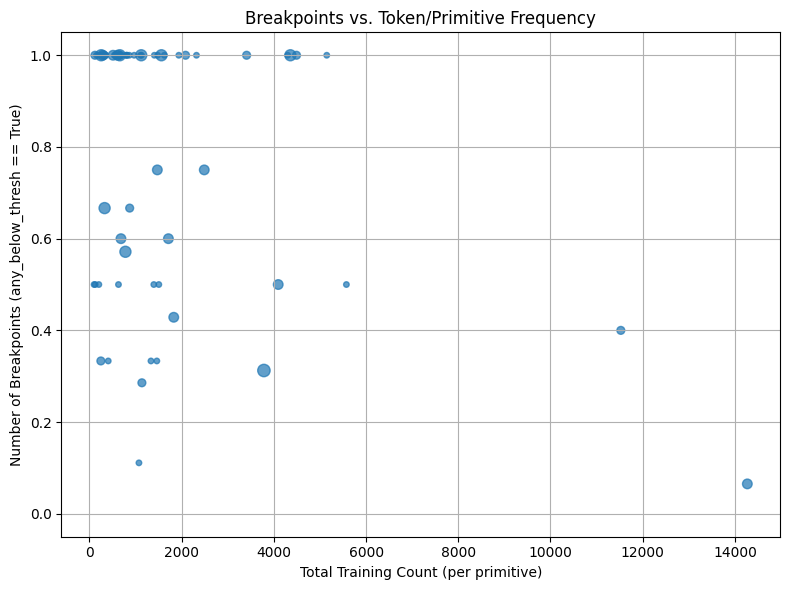

Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors


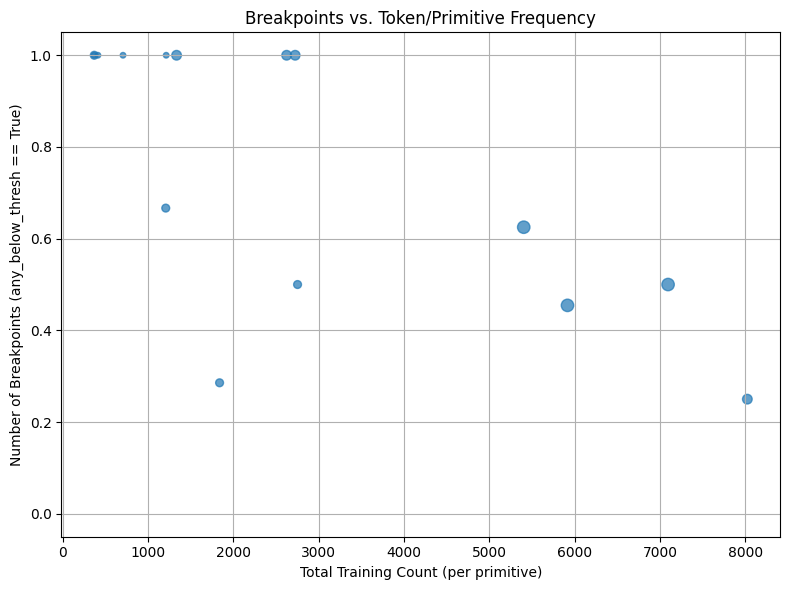

In [45]:
def plot_scatter_graph_of_frequency(primitives): 
    prim_counts = {item: 0 for item in primitives}

    for prim in prim_counts.keys(): 
        for task in train_tasks:
            count = task.program_lines.count(prim)
            prim_counts[prim] += count

    tokenizer = AutoTokenizer.from_pretrained("Salesforce/codet5p-220m")
    tokenized_primitive_functions = [(x, tokenizer(x, add_special_tokens=False)['input_ids']) for x in primitives]

    tokens, token_probs = compute_probs_and_token_ids(validation_tasks, '../finetune-checkpoint/dev-checkpoint' )


    stats = {}
    for pair in tokenized_primitive_functions:
        name, tpf_tokens = pair
        stats[name] = []

        for i in range(len(tokens)):

            task_tokens = tokens[i]
            task_token_probs = token_probs[i]

            start_idx = find_subsequence(task_tokens, tpf_tokens)
            if start_idx != -1:
                end_idx = start_idx + len(tpf_tokens)
                matched_probs = task_token_probs[start_idx:end_idx]
                stats[name].append(matched_probs)


    threshold = 0.1
    rows = []
    for primitive, prob_lists in stats.items():
            for probs in prob_lists:
                if probs:  # skip empty inner lists just in case
                    any_below_thresh = any(p < threshold for p in probs)
                    rows.append({
                        'primitive': primitive,
                        'token_probs': probs,
                        'any_below_thresh': any_below_thresh,
                        'training_count': prim_counts[primitive]
                    })

        # Create the DataFrame
    df = pd.DataFrame(rows)
    summary = (
    df.groupby('primitive')
    .agg(
        num_occurrences=('token_probs', 'count'),
        num_with_low_token=('any_below_thresh', 'sum'),
        frac_with_low_token=('any_below_thresh', 'mean'),
        total_training_count=('training_count', 'first')  # assumes it's constant per primitive
    )
    .sort_values('frac_with_low_token', ascending=False)
    )
    # Scatter plot: training count vs. breakpoint count
    plt.figure(figsize=(8, 6))
    plt.scatter(
    summary["total_training_count"],
    summary["frac_with_low_token"],
    s=summary["num_with_low_token"] * 16,  # bubble size
    alpha=0.7
)

    # Annotate points with primitive names (optional, useful for analysis)
    #for primitive, row in summary.iterrows():
    #    plt.annotate(primitive, (row["total_training_count"], row["num_with_low_token"]))

    plt.xlabel("Total Training Count (per primitive)")
    plt.ylabel("Number of Breakpoints (any_below_thresh == True)")
    plt.title("Breakpoints vs. Token/Primitive Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



def collapse_dict_values(data):
    unique_items = set()
    for values in data.values():
        unique_items.update(values)
    return list(unique_items)

from alphaarc.dsl.primitives import PRIMITIVE_FUNCTIONS, PRIMITIVE_CONSTANTS


PRIMITIVE_CONSTANTS = collapse_dict_values(PRIMITIVE_CONSTANTS)


plot_scatter_graph_of_frequency(PRIMITIVE_FUNCTIONS)
plot_scatter_graph_of_frequency(PRIMITIVE_CONSTANTS)